In [20]:
#import necessary packages

#our workhorses
import numpy as np
import pandas as pd
import scipy

#to visualize
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#style params for figures
sns.set(font_scale = 2)
plt.style.use('seaborn-white')
plt.rc("axes", labelweight="bold")
from IPython.display import display, HTML

#to load files
import os
import h5py

#for stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multitest as multitest
import statsmodels.stats.multicomp

#load custon functions
import sys

from EMG_gestures.utils import *

In [39]:
results_folder = '../results_data/xsubject_transform_module/log_reg'

results_df = []
for model_id in range(1,5+1):
    # load model results
    results_fn = 'model_%02d_results.h5'%(model_id)
    model_df = pd.read_hdf(os.path.join(results_folder,results_fn), 'results_df')
    model_df['Model'] = model_id
    #append to collective dataframe
    results_df.append(model_df)
results_df = pd.concat(results_df,axis = 0)

In [40]:
# Average over multiple train/test splits of the data
results_df = results_df.groupby(['Shuffled','Type','Model','Rep'],as_index = False)\
.mean()\
.drop(columns = ['Fold','Subject'])

In [44]:
#drop accuracy score, working with f1 score
results_df = results_df.drop(columns=['accuracy_score'])

train_results_df = results_df.loc[results_df.Type == 'Train']
test_results_df = results_df.loc[results_df.Type == 'Val_Test']

train_summary = train_results_df.groupby(['Shuffled','Model']).mean().\
drop(columns = ['Rep']).\
rename(columns={'f1_score':'Train_score'})

test_summary = test_results_df.groupby(['Shuffled','Model']).mean().\
drop(columns = ['Rep']).\
rename(columns={'f1_score':'Test_score'})

summary_df = pd.concat([train_summary,test_summary],axis = 1)
summary_df

Train_score  Test_score
Shuffled Model                         
False    1         0.968636    0.921604
         2         0.969916    0.920521
         3         0.965990    0.905704
         4         0.961844    0.912065
         5         0.942603    0.856427
True     1         0.423118    0.109938
         2         0.445815    0.111162
         3         0.481690    0.100254
         4         0.411149    0.100995
         5         0.393870    0.079569

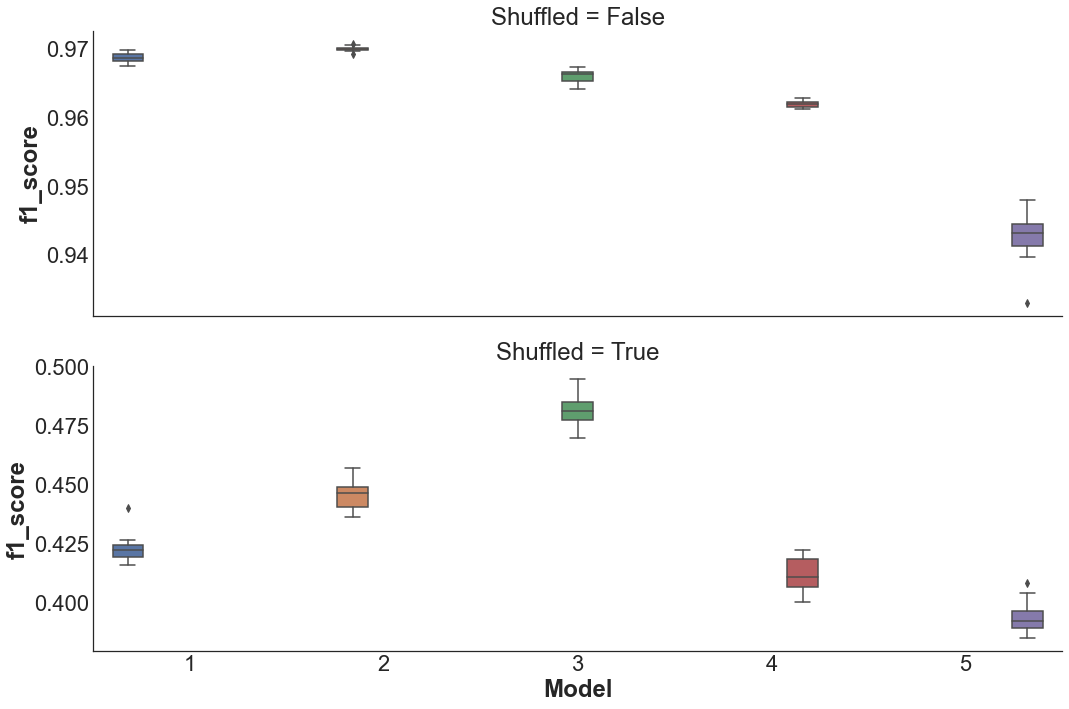

In [45]:
g = sns.catplot(data = train_results_df, x= 'Model', y = 'f1_score', col = 'Shuffled', hue = 'Model',\
            kind = 'box', col_order = [False,True], col_wrap = 1, aspect = 3, sharey = False)

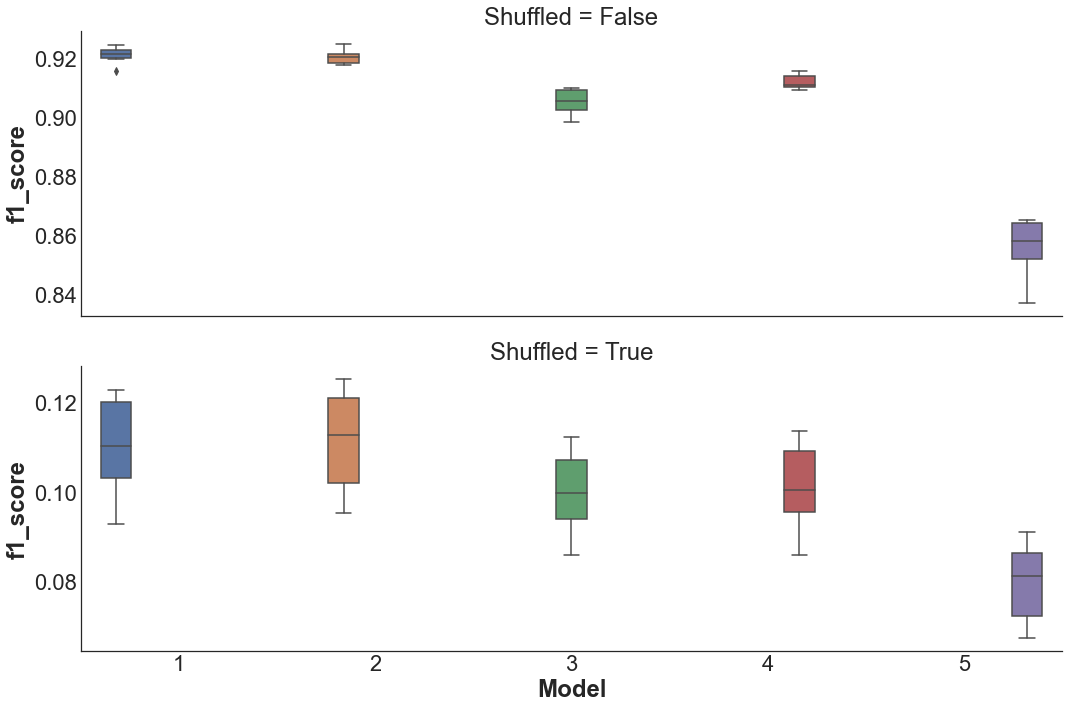

In [46]:
g = sns.catplot(data = test_results_df, x= 'Model', y = 'f1_score', col = 'Shuffled', hue = 'Model',\
            kind = 'box', col_order = [False,True], col_wrap = 1, aspect = 3, sharey = False)

In [47]:
results_true_df = results_df.loc[results_df.Shuffled == False]

In [50]:
# Run ANOVA
model = ols('f1_score ~ C(Model)*C(Type)', results_true_df).fit()

# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res

,sum_sq,df,F,PR(>F)
C(Model),0.052495,4.0,1068.491789,4.238149e-101
C(Type),0.108463,2.0,4415.386119,9.950834e-124
C(Model):C(Type),0.006381,8.0,64.941089,1.492962e-42
Residual,0.001658,135.0,NaN,NaN


In [51]:
groups =  results_true_df['Model'].map(str) + ' - ' + results_true_df['Type'].map(str)

mc = statsmodels.stats.multicomp.MultiComparison(results_true_df['f1_score'],groups)
mc_results = mc.tukeyhsd()
print(mc_results)


       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2    meandiff p-adj   lower   upper  reject
------------------------------------------------------------------
    1 - Train  1 - Val_Test   -0.047  0.001 -0.0524 -0.0416   True
    1 - Train 1 - Val_Train   0.0043 0.2879 -0.0011  0.0097  False
    1 - Train     2 - Train   0.0013    0.9 -0.0041  0.0067  False
    1 - Train  2 - Val_Test  -0.0481  0.001 -0.0535 -0.0427   True
    1 - Train 2 - Val_Train   0.0056 0.0344  0.0002   0.011   True
    1 - Train     3 - Train  -0.0026    0.9 -0.0081  0.0028  False
    1 - Train  3 - Val_Test  -0.0629  0.001 -0.0683 -0.0575   True
    1 - Train 3 - Val_Train  -0.0009    0.9 -0.0063  0.0045  False
    1 - Train     4 - Train  -0.0068 0.0025 -0.0122 -0.0014   True
    1 - Train  4 - Val_Test  -0.0566  0.001  -0.062 -0.0512   True
    1 - Train 4 - Val_Train   -0.005 0.1121 -0.0104  0.0005  False
    1 - Train     5 - Train   -0.026  0.001 -0.0314 -0.0206   

In [52]:
test_results_true_df = results_df.loc[(results_df.Type == 'Val_Test')&(results_df.Shuffled == False)]
train_results_true_df = results_df.loc[(results_df.Type == 'Train')&(results_df.Shuffled == False)]


In [53]:
# Run ANOVA
model = ols('f1_score ~ C(Model)', test_results_true_df).fit()

# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res

,sum_sq,df,F,PR(>F)
C(Model),0.029113,4.0,314.360864,2.962546e-32
Residual,0.001042,45.0,NaN,NaN


In [55]:
groups =  test_results_true_df['Model'].map(str) #+ ' - ' + test_results_true_df['Shuffled'].map(str)

mc = statsmodels.stats.multicomp.MultiComparison(test_results_true_df['f1_score'],groups)
mc_results = mc.tukeyhsd()
print(mc_results)

#p_values = psturng(np.abs(mc_results.meandiffs / mc_results.std_pairs), len(mc_results.groupsunique), mc_results.df_total)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2  -0.0011    0.9 -0.0072   0.005  False
     1      3  -0.0159  0.001  -0.022 -0.0098   True
     1      4  -0.0095  0.001 -0.0157 -0.0034   True
     1      5  -0.0652  0.001 -0.0713 -0.0591   True
     2      3  -0.0148  0.001 -0.0209 -0.0087   True
     2      4  -0.0085 0.0026 -0.0146 -0.0023   True
     2      5  -0.0641  0.001 -0.0702  -0.058   True
     3      4   0.0064 0.0378  0.0002  0.0125   True
     3      5  -0.0493  0.001 -0.0554 -0.0432   True
     4      5  -0.0556  0.001 -0.0618 -0.0495   True
----------------------------------------------------
